<a href="https://colab.research.google.com/github/lollipop6370/ML2021/blob/main/hw12_ppo_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Package And Building Environment

In [1]:
!apt update
!apt install python3-opengl xvfb -y
!pip uninstall box2d box2d-py -y
!pip install swig
!pip install box2d-py==2.3.8
!pip install gymnasium[box2d] --no-deps
!pip install pyvirtualdisplay tqdm numpy torch

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,804 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,081 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [48.5 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,092 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4,917 kB]
Hit:13 https://ppa.

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
import itertools

In [3]:
seed = 543 # Do not change this (543)
def fix(env, seed):
  obs, info = env.reset(seed=seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.use_deterministic_algorithms(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [4]:
%%capture
import gymnasium as gym
import random
import numpy as np

env = gym.make('LunarLander-v3', render_mode="rgb_array")

fix(env, seed)

import time
start = time.time()

In [5]:
!pip freeze

absl-py==1.4.0
accelerate==1.8.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.11.15
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.1
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.9.0
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
array_record==0.7.2
arviz==0.21.0
astropy==7.1.0
astropy-iers-data==0.2025.6.30.0.39.40
astunparse==1.6.3
atpublic==5.1
attrs==25.3.0
audioread==3.0.1
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
backports.tarfile==1.2.0
beautifulsoup4==4.13.4
betterproto==2.0.0b6
bigframes==2.8.0
bigquery-magics==0.9.0
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.0.0
blosc2==3.5.0
bokeh==3.7.3
Bottleneck==1.4.2
box2d-py==2.3.8
bqplot==0.12.45
branca==0.8.1
build==1.2.2.post1
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.6.15
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.2
chex==0.1.89
clarabel==0.11.1
click==8.2.1
cloudpathlib==0.21.1
cloudpickle==3.1.1
cmake=

# 1. Building Actor And Critic Network

# Actor

In [6]:
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 4),
            nn.Softmax(dim=-1)
        )

    def forward(self, observation):
        action = self.net(observation)
        return action

# Critic

In [7]:
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, observation):
        return self.net(observation)

# 2. Building AI Agent

In [8]:
class Agent():
    def __init__(self):
        # hyperparameter
        self.gamma = 0.99
        self.epsilon = 0.2
        self.kepochs = 8

        self.memory = []
        self.loss_critic_record = []
        #self.loss_actor_recrod = []
        #self.loss_entropy_record = []

        self.lr = 8e-4
        #self.lr_actor = 8e-4
        #self.lr_critic = 8e-4

        # 1. create actor and critic
        self.actor = Actor()
        self.actor_old = Actor()
        self.actor_old.load_state_dict(self.actor.state_dict())
        self.critic = Critic()

        # 2. determined optimizer
        self.all_parameters = itertools.chain(self.actor.parameters(), self.critic.parameters())
        self.optimizer = optim.Adam(self.all_parameters, lr=self.lr)
        #self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=self.lr_actor)
        #self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=self.lr_critic)

    # 3. sampling a action
    def sample(self, observation):
        # sample a action from old actor.
        observation_tensor = torch.tensor(observation, dtype=torch.float32)
        action_prob = self.actor_old(observation_tensor)
        action_dist = Categorical(action_prob)
        action = action_dist.sample()
        log_prob = action_dist.log_prob(action)

        return action.item(), log_prob

    # 4. learning
    def learn(self):

        # take data from memory
        observations, actions, old_log_probs, rewards, dones = zip(*self.memory)
        # change data type to tensor
        observations_tensor = torch.tensor(np.array(observations), dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.int64)
        old_log_probs = torch.stack(old_log_probs).detach()

        # calculat discount rewards
        discount_rewards = 0
        rewards_to_go = []
        for r, done in zip(reversed(rewards), reversed(dones)):
            if done:
                discount_rewards = 0
            discount_rewards = r + discount_rewards * self.gamma
            rewards_to_go.insert(0, discount_rewards)
        # change data type
        rewards_to_go_tensor = torch.tensor(rewards_to_go, dtype=torch.float32)

        #with torch.no_grad():
        #    values_for_gae = self.critic(observations_tensor).squeeze()

        # calculate GAE advantage
        #advantage = self.compute_gae(rewards, values_for_gae, dones)
        # normalization advantage
        #advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

        # training module for kepochs
        for epoch in range(self.kepochs):

            # get critic value
            value = self.critic(observations_tensor).squeeze()

            # take new actor's distribution
            action_prob = self.actor(observations_tensor)
            action_dist = Categorical(action_prob)
            new_log_prob = action_dist.log_prob(actions_tensor)

            # take entropy
            entropys_tensor = action_dist.entropy()

            # calculate ratio
            # we need new_prob / old_prob
            # exp(log(a)-log(b)) = exp(log(a/b)) = a/b
            ratio = torch.exp(new_log_prob - old_log_probs)

            # calculate advantage
            advantage = (rewards_to_go_tensor - value).detach()
            # normalization
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

            # actor loss
            loss_actor = - torch.min(ratio * advantage, torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantage).mean()

            # critic loss
            loss_critic = F.mse_loss(value, rewards_to_go_tensor)
            self.loss_critic_record.append(loss_critic.item())

            # entropy loss
            loss_entropy = - entropys_tensor.mean()

            # loss function
            loss = loss_actor + 1.0 * loss_critic + 0.01 * loss_entropy
            loss_actor_entropy = loss_actor + 0.01 * loss_entropy

            # update actor
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            #self.optimizer_actor.zero_grad()
            #loss_actor_entropy.backward()
            #self.optimizer_actor.step()

            #self.optimizer_critic.zero_grad()
            #loss_critic.backward()
            #self.optimizer_critic.step()


        self.actor_old.load_state_dict(self.actor.state_dict())

        # clean memory
        self.memory = []

    def compute_gae(self, rewards, values, dones, lam=0.95):
        """
        rewards: List of float
        values: torch.Tensor, shape [T], detached
        dones: List of bool
        """
        advantages = []
        gae = 0
        values = values.tolist() + [0.0]  # append V(s_{T+1}) = 0 for terminal
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t + 1] * (1 - dones[t]) - values[t]
            gae = delta + self.gamma * lam * (1 - dones[t]) * gae
            advantages.insert(0, gae)

        return torch.tensor(advantages, dtype=torch.float32)

    def store_transition(self, observation, action, log_prob, reward, done):
        self.memory.append((observation, action, log_prob, reward, done))

    # 5. save module
    def save(self, PATH):
        dictionary = {
            "network": {
                "actor": self.actor.state_dict(),
                "critic": self.critic.state_dict()
            },
            "optimizer": self.optimizer.state_dict()
        }
        torch.save(dictionary, PATH)

    # 6. load module
    def load(self, PATH):
        checkpoint = torch.load(PATH)
        self.actor.load_state_dict(checkpoint["network"]["actor"])
        self.critic.load_state_dict(checkpoint["network"]["critic"])
        self.optimizer.load_state_dict(checkpoint["optimizer"])
        self.actor_old.load_state_dict(self.actor.state_dict())

# 3. Training

In [9]:
agent = Agent()

In [10]:
# initial some setting
agent.actor.train()
agent.critic.train()
MAX_STEP = 2500000 # total training step
UPDATE_STEP = 2048 # unmber of update step
time_step = 0

observation, _ = env.reset() #
avg_rewards_per_batch = []
episode_reward = []
reward_sum = 0
count = 0

# training start
prg_bar = tqdm(range(MAX_STEP))
for step in prg_bar:

    # Learning Rate Annealing
    frac = 1.0 - (step - 1.0) / MAX_STEP
    new_lr = agent.lr * frac
    for param_group in agent.optimizer.param_groups:
        param_group["lr"] = new_lr
    #frac = 1.0 - (step - 1.0) / MAX_STEP
    #new_lr_actor = agent.lr_actor * frac
    #new_lr_critic = agent.lr_critic * frac
    #for param_group in agent.optimizer_actor.param_groups:
    #    param_group["lr"] = new_lr_actor
    #for param_group in agent.optimizer_critic.param_groups:
    #    param_group["lr"] = new_lr_critic

    # step for episode
    count += 1

    # 1. sample action from old actor.
    action, log_prob = agent.sample(observation)

    # 2. interact with the environment.
    next_observation, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    reward_sum += reward

    # 3. save data
    agent.store_transition(observation, action, log_prob, reward, done)

    observation = next_observation
    time_step += 1


    if done:
        print(f"episode finished. reward = {reward_sum}, step = {count}, terminated = {terminated}, truncated = {truncated}")
        episode_reward.append(reward_sum)
        reward_sum = 0
        count = 0
        observation, _ = env.reset() #

    # 4. if collect enough data, update module.
    if time_step % UPDATE_STEP == 0:
        if len(episode_reward) != 0:
            avg_rewards_per_batch.append(sum(episode_reward) / len(episode_reward))
            print(f"every episode average reward = ", sum(episode_reward) / len(episode_reward))
            episode_reward = []
        agent.learn()
        time_step = 0

  0%|          | 0/2500000 [00:00<?, ?it/s]

episode finished. reward = -436.45912417101454, step = 85, terminated = True, truncated = False
episode finished. reward = -321.05165751398073, step = 90, terminated = True, truncated = False
episode finished. reward = -296.7751271847517, step = 129, terminated = True, truncated = False
episode finished. reward = -70.24729772123618, step = 63, terminated = True, truncated = False
episode finished. reward = -100.46292205175686, step = 82, terminated = True, truncated = False
episode finished. reward = -203.4469456351418, step = 60, terminated = True, truncated = False
episode finished. reward = -124.1681076097129, step = 118, terminated = True, truncated = False
episode finished. reward = -615.264331712892, step = 103, terminated = True, truncated = False
episode finished. reward = -81.12256560515534, step = 109, terminated = True, truncated = False
episode finished. reward = -316.53195745491485, step = 77, terminated = True, truncated = False
episode finished. reward = -175.90307857956

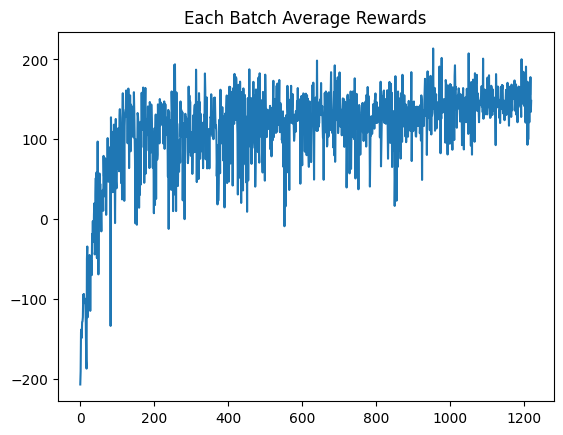

In [11]:
end = time.time()
plt.plot(avg_rewards_per_batch)
plt.title("Each Batch Average Rewards")
plt.show()

[18167.21875, 18153.30078125, 18139.3984375, 18125.484375, 18111.541015625, 18097.54296875, 18083.466796875, 18069.28125, 16585.19140625, 16573.8671875, 16562.162109375, 16550.13671875, 16537.82421875, 16525.23828125, 16512.3828125, 16499.255859375, 9198.2470703125, 9188.861328125, 9179.404296875, 9169.8544921875, 9160.1865234375, 9150.3828125, 9140.42578125, 9130.296875, 7126.9609375, 7116.32470703125, 7105.44384765625, 7094.3095703125, 7082.91748046875, 7071.26123046875, 7059.3359375, 7047.138671875, 8645.365234375, 8632.4033203125, 8619.126953125, 8605.537109375, 8591.6357421875, 8577.4287109375, 8562.919921875, 8548.111328125, 6251.5400390625, 6238.3486328125, 6224.8828125, 6211.15966796875, 6197.19482421875, 6183.0048828125, 6168.6044921875, 6154.009765625, 7387.255859375, 7372.34912109375, 7357.28369140625, 7342.0732421875, 7326.73193359375, 7311.2734375, 7295.71044921875, 7280.0556640625, 6669.013671875, 6654.87353515625, 6640.755859375, 6626.6611328125, 6612.5908203125, 6598.54

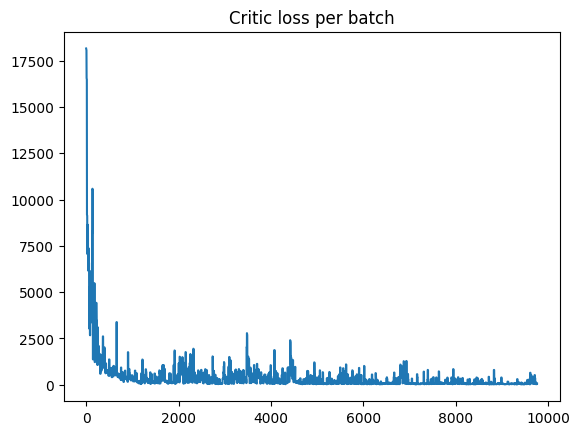

In [12]:
print(agent.loss_critic_record)
plt.plot(agent.loss_critic_record)
plt.title("Critic loss per batch")
plt.show()

# Test

episode finished ! reward =  157.83459904405234
lenght of actions =  1000
episode finished ! reward =  146.72887974666452
lenght of actions =  1000
episode finished ! reward =  164.4203024634089
lenght of actions =  1000
episode finished ! reward =  123.8556017723624
lenght of actions =  1000
episode finished ! reward =  132.60654939564176
lenght of actions =  1000


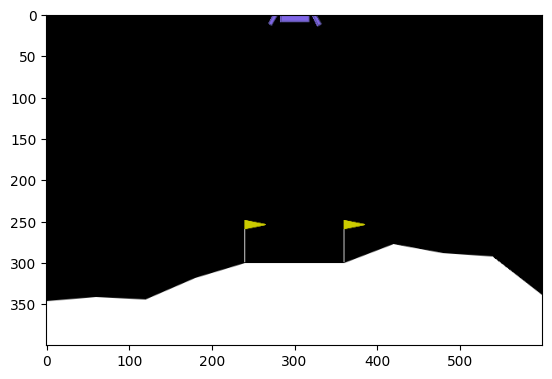

In [13]:
fix(env, seed)
agent.actor.eval()
agent.critic.eval()
NUM_OF_TEST = 5 #
test_total_reward = []
action_lists = []
for i in range(NUM_OF_TEST):
    observation, _ = env.reset() # random seed

    img = plt.imshow(env.render())

    rewards = 0
    action_list = []
    while True:
        action, log_prob = agent.sample(observation)
        observation, reward, termination, truncated, _ = env.step(action)
        rewards += reward
        action_list.append(action)

        #img.set_data(env.render())
        #display.display(plt.gcf())
        #display.clear_output(wait=True)

        done = termination or truncated
        if done:
            test_total_reward.append(rewards)
            action_lists.append(action_list)
            print(f"episode finished ! reward = ", rewards)
            print(f"lenght of actions = ", len(action_list))
            break

In [14]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 145.09


In [15]:
print("Action list looks like ", action_lists)
print("Action list's shape looks like ", len(action_lists))

Action list looks like  [[0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 0, 0, 3, 1, 0, 0, 0, 1, 3, 1, 0, 1, 0, 0, 0, 2, 3, 0, 3, 1, 1, 2, 2, 2, 2, 3, 3, 1, 2, 2, 3, 2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 1, 2, 2, 2, 2, 2, 0, 2, 3, 2, 2, 2, 2, 3, 0, 2, 2, 3, 2, 1, 2, 2, 2, 0, 3, 2, 2, 2, 2, 3, 3, 2, 2, 1, 2, 0, 2, 3, 2, 1, 0, 1, 2, 2, 2, 3, 2, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 3, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 3, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 2, 3, 0, 2, 2, 3, 3, 1, 2, 2, 1, 2, 0, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 2, 3, 0, 2, 0, 2, 2, 2, 3, 3, 2, 3, 0, 2, 1, 2, 3, 0, 2, 2, 1, 1, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 3, 2, 3, 1, 2, 1, 2, 2, 2, 2, 0, 3, 2, 1, 2, 2, 2, 2, 2, 3, 0, 0, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 0, 0, 3, 3, 0, 3, 0, 3, 3, 0, 3, 0, 3, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 0, 3, 0, 0, 3, 0, 3, 3, 0, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 1, 3, 3, 0, 0, 1, 0, 0, 0, 3, 1, 3, 3, 0, 0, 1, 0, 0, 0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 3, 3, 3, 1, 3, 3, 0, 3, 0, 3, 0, 0, 3, 1, 3, 3, 3, 0, 3, 0, 3, 3,

In [16]:
distribution = {}
for action_list in action_lists:
    for action in action_list:
        if action not in distribution.keys():
            distribution[action] = 1
        else:
            distribution[action] += 1
print(distribution)

{0: 1981, 1: 984, 3: 1400, 2: 635}
